In [1]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)
#config.update('jax_debug_nans', True) #this checks outputs for nans everytime and reruns the function with non-optimized mode.


import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 16}
matplotlib.rc('font', **font)
# from NODE_fns import NODE
from jax import grad, random, jit, jacobian, jacfwd, jacrev
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import while_loop, fori_loop, scan
import pickle
key = random.PRNGKey(0)


In [2]:
# N-ODE based Φ
# with open('saved/norm_w_jax.npy', 'rb') as f:
#     [inp_mean, inp_stdv, out_mean, out_stdv] = pickle.load(f)

# def dPhi(taui, params):
#     NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = params
    
#     tau1 = taui[0]
#     tau2 = taui[1]
#     tau3 = taui[2]

#     tau1 = (tau1 - inp_mean)/inp_stdv
#     tau2 = (tau2 - inp_mean)/inp_stdv
#     tau3 = (tau3 - inp_mean)/inp_stdv

#     N1 = NODE(tau1, NODE1_params)
#     N2 = NODE(tau1 + tau2, NODE2_params)
#     N3 = NODE(tau1 + tau2 + tau3, NODE3_params)
#     N4 = NODE(tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3, NODE4_params)
#     N5 = NODE(tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3, NODE5_params)

#     Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
#     Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
#     Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

#     Phi1 = Phi1*out_stdv + out_mean
#     Phi2 = Phi2*out_stdv + out_mean
#     Phi3 = Phi3*out_stdv + out_mean
#     return [Phi1, Phi2, Phi3]

# d2Phi = jacobian(dPhi, argnums=0)

In [3]:
# Material parameters:
mu_m = np.array([51.4, -18, 3.86])
alpha_m = np.array([1.8, -2, 7])
K_m = 10000
tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*K_m
mu = 77.77 #=shear_mod
K = 10000

In [4]:
def innerNR(iterables, eps_e_trial, dt, params):
    normres, itr, eps_e = iterables
    
    lamb_e = np.exp(eps_e)
    Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
    bbar_e = Je**(-2/3)*lamb_e**2 #(54)

    b1 = bbar_e[0]
    b2 = bbar_e[1]
    b3 = bbar_e[2]

    #Calculate K_AB
    ddev11 = 0
    ddev12 = 0
    ddev13 = 0
    ddev22 = 0
    ddev23 = 0
    ddev33 = 0

    for r in range(3):
        e = alpha_m[r]/2
        ddev11 = ddev11 + mu_m[r]*(2*e)*( 4/9*b1**e + 1/9*(b2**e + b3**e)) #(B12)
        ddev22 = ddev22 + mu_m[r]*(2*e)*( 4/9*b2**e + 1/9*(b1**e + b3**e))
        ddev33 = ddev33 + mu_m[r]*(2*e)*( 4/9*b3**e + 1/9*(b1**e + b2**e))

        ddev12 = ddev12 + mu_m[r]*(2*e)*(-2/9*(b1**e + b2**e) + 1/9*b3**e) #(B13)
        ddev13 = ddev13 + mu_m[r]*(2*e)*(-2/9*(b1**e + b3**e) + 1/9*b2**e)
        ddev23 = ddev23 + mu_m[r]*(2*e)*(-2/9*(b2**e + b3**e) + 1/9*b1**e)
    ddev = np.array([[ddev11, ddev12, ddev13],[ddev12, ddev22, ddev23], [ddev13, ddev23, ddev33]])

    K_AB = np.eye(3) + dt/2/eta_D*ddev - dt/3/eta_V*K_m*Je**2*np.ones([3,3]) #(B15)
    K_AB_inv = np.linalg.inv(K_AB)

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)

    # Use Neural ODE based approach:
    # tau_A = devtau + 1/3*tau_NEQI #(B8)
    # order = np.argsort(-tau_A)

    # d2phid2tau = np.array(d2Phi(tau_A[order], params)) #Get the 2nd derivatives of Phi with NODEs

    # dtaui_depsej = ddev + K_m*Je**2
    # dtaui_depsej = dtaui_depsej[order] #-tau_A.argsort sorts descending order which is what I need.

    # K_AB = np.eye(3) + dt*np.dot(d2phid2tau, dtaui_depsej)
    # K_AB_inv = np.linalg.inv(K_AB)
    
    res = eps_e + dt*(1/2/eta_D*devtau + 1/9/eta_V*tau_NEQI*np.ones(3))-eps_e_trial #(60)
    deps_e = np.dot(K_AB_inv, -res)
    eps_e = eps_e + deps_e
    normres = np.linalg.norm(res)
    itr+= 1
    return [normres, itr, eps_e]


def evalGovindjee(F, C_i_inv, dt, params):
    #Preprocessing
    be_trial = np.dot(F, np.dot(C_i_inv, F.transpose()))
    lamb_e_trial, n_A = np.linalg.eigh(be_trial)
    n_A = np.real(n_A)
    lamb_e_trial = np.sqrt(np.real(lamb_e_trial) + 1.0e-6)
    eps_e_trial = np.log(lamb_e_trial + 1.0e-6)
    eps_e = eps_e_trial #Initial guess for eps_e
    
    #Inner Neuton Raphson
    normres = 1.0
    itr = 0
    itermax = 20
    cond_fun = lambda x: np.sign(x[0]-1.e-6) + np.sign(itermax - x[1]) > 0
    body_fun = lambda iterables: innerNR(iterables, eps_e_trial, dt, params)
    normres, itr, eps_e = while_loop(cond_fun, body_fun, [normres,itr, eps_e])
    lamb_e = np.exp(eps_e)
    Je = lamb_e[0]*lamb_e[1]*lamb_e[2]
    bbar_e = Je**(-2/3)*lamb_e**2 #(54)

    b1 = bbar_e[0]
    b2 = bbar_e[1]
    b3 = bbar_e[2]

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))

    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*K_m/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    tau_NEQ = tau_A[0]*np.outer(n_A[:,0], n_A[:,0]) + tau_A[1]*np.outer(n_A[:,1], n_A[:,1]) + tau_A[2]*np.outer(n_A[:,2], n_A[:,2]) #(58)
    b = np.dot(F,F.transpose())
    J = np.linalg.det(F)
    sigma_EQ = mu/J*(b-np.eye(3)) + 2*K*(J-1)*np.eye(3) #neo Hookean material
    sigma = 1/Je*tau_NEQ + sigma_EQ #(7)
    
    #Post processing
    be = np.einsum('i,ji,ki->jk', lamb_e**2, n_A, n_A)
    F_inv = np.linalg.inv(F)
    C_i_inv_new = np.dot(F_inv, np.dot(be, F_inv.transpose()))
    return sigma, C_i_inv_new

In [5]:
def outerNR(iterables, eps_x, eps_y, sigma_z, C_i_inv, dt, params):
    res, itr, eps_z = iterables 
    lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z 
    F    = np.array([[lmx,   0,    0], 
                     [0,    lmy,   0], 
                     [0,    0,   lmz]])
    sigma, _ = evalGovindjee(F, C_i_inv, dt, params)
    res = sigma[2,2]-sigma_z

    # calculate dres with NR 
    F_pz = np.array([[lmx,   0,    0], 
                     [0,    lmy  , 0], 
                     [0, 0, lmz+1e-6]])
    sigma_pz, _ = evalGovindjee(F_pz, C_i_inv, dt, params)
    
    dres = (sigma_pz[2,2]-sigma[2,2])/1e-6
    
    deps = -res/dres
    eps_z += deps
    itr+=1 
    normres = np.abs(res)
    return [normres, itr, eps_z]

def timeloop(C_i_inv, strains, dt, params):
    eps_x, eps_y = strains 
    normres = 1.0
    itr = 0
    itermax = 20
    cond_fun = lambda x: np.sign(x[0]-1.e-6) + np.sign(itermax - x[1]) > 0
    body_fun = lambda inputs: outerNR(inputs, eps_x, eps_y, 0.0, C_i_inv, dt, params)
    iterables = while_loop(cond_fun, body_fun, [normres, itr, 0.0])
    res, itr, eps_z = iterables
    
    lmx, lmy, lmz = 1+eps_x, 1+eps_y, 1+eps_z
    F = np.array([[lmx,   0,    0], 
                  [0,    lmy,   0], 
                  [0,    0,   lmz]])
    sigma, C_i_inv_new = evalGovindjee(F, C_i_inv, dt, params)
    return C_i_inv_new, sigma

@jit
def biaxial_visco(eps_x, eps_y, dt, params):
    C_i_inv = np.eye(3)
    body_fun = lambda C_i_inv, strains: timeloop(C_i_inv, strains, dt, params)
    C_i_inv, sigma_vec = scan(body_fun, C_i_inv, [eps_x, eps_y])
    
    return sigma_vec

In [6]:
# Load (trained) parameters and training data
# with open('saved/params_jax.npy', 'rb') as f:
#     params = pickle.load(f)
params = []
with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sigma_x, sigma_y = np.load(f)
eps_x = lmb_x-1
eps_y = lmb_y-1

In [7]:
# Predict sigma
#which curve do you want to work with?
itest = 0
sigma_pr = biaxial_visco(eps_x[itest], eps_y[itest], 1.0, params) 

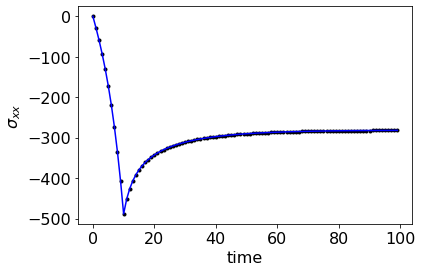

In [8]:
# Plot the predicted sigma
fig, ax = plt.subplots()
ax.plot(time[itest], sigma_x[itest], 'k.')
ax.plot(time[itest], sigma_pr[:,0,0],'b-')
ax.set(xlabel='time', ylabel = '$\sigma_{xx}$')
pass